#Introduction to Computer Vision

#### Term Project : CIFAR-10 K-Nearest Neighbor (KNN) assignment
#### 202111941 PARK SEJIN

In [1]:
# Cell 1: Import required libraries

import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# Cell 2: KNearestNeighbor class
# - Supports vectorized distance computation (no Python for-loops)
# - Includes sqrt for accurate Euclidean distance
# - Supports 'l1' (Manhattan) and 'l2' (Euclidean)
# - Faster and numerically more stable than loop version


class KNearestNeighbor:
    def __init__(self, k=1, metric='l2'):
        self.k = k
        self.metric = metric

    def train(self, X, y):
        self.Xtr = X
        self.ytr = y

    # L1 distance computation using chunked processing
    def compute_distances_L1_chunked(self, X, chunk_size=100):
        N_test = X.shape[0]
        N_train = self.Xtr.shape[0]
        dists = np.zeros((N_test, N_train), dtype=np.float32)

        # Process test samples in small chunks to avoid memory explosion
        for start in range(0, N_test, chunk_size):
            end = min(start + chunk_size, N_test)
            # Compute |x - y| in a memory-safe way
            dists[start:end] = np.sum(
                np.abs(self.Xtr[None, :, :] - X[start:end, None, :]), axis=2
            )
        return dists

    def compute_distances_no_loop(self, X):
        """Vectorized computation of L1 or L2 distances."""
        if self.metric == 'l1':
            # Use chunked computation for L1 to prevent out-of-memory issues
            return self.compute_distances_L1_chunked(X, chunk_size=100)

        elif self.metric == 'l2':
            # sqrt(||x||^2 + ||y||^2 - 2x·y)
            X_square = np.sum(X**2, axis=1, keepdims=True)  # (N_test, 1)
            Xtr_square = np.sum(self.Xtr**2, axis=1)        # (N_train,)
            dists = np.sqrt(np.maximum(
                X_square + Xtr_square - 2 * np.dot(X, self.Xtr.T),
                0.0
            ))
            return dists
        else:
            raise ValueError("Unsupported metric. Use 'l1' or 'l2'.")

    def predict(self, X):
        """Predict labels for test data X."""
        dists = self.compute_distances_no_loop(X)

        num_test = X.shape[0]
        Ypred = np.zeros(num_test, dtype=self.ytr.dtype)

        for i in range(num_test):
            nearest_idxs = np.argsort(dists[i])[:self.k]
            nearest_labels = self.ytr[nearest_idxs]
            Ypred[i] = Counter(nearest_labels).most_common(1)[0][0]

        return Ypred


In [3]:
# Cell 3: Load and preprocess CIFAR-10 dataset
# - Flatten images to vectors of size (3072,)
# - Apply z-score standardization instead of simple /255.0 normalization

transform = transforms.Compose([transforms.ToTensor()])
trainset = CIFAR10(root="./data", train=True, download=True, transform=transform)
testset = CIFAR10(root="./data", train=False, download=True, transform=transform)

X_train = trainset.data.reshape(len(trainset.data), -1).astype(np.float32)
y_train = np.array(trainset.targets)
X_test = testset.data.reshape(len(testset.data), -1).astype(np.float32)
y_test = np.array(testset.targets)

# z-score standardization
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0) + 1e-8
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (50000, 3072) Test: (10000, 3072)


In [4]:
# Cell 4: Train/Test split (Baseline)
# - Use full training set for training
# - Fix k=5 (a common default choice in KNN)
# - Evaluate on a subset of the test set
# - Report Accuracy, Precision, Recall, F1-score
# - Purpose: Provide a baseline performance
#   before tuning k with validation or CV

knn = KNearestNeighbor(k=5)
knn.train(X_train, y_train)
y_pred = knn.predict(X_test[:2000])      # subset for speed

print("== Train/Test Split (Baseline, k=5) ==")
print("Accuracy :", accuracy_score(y_test[:2000], y_pred))
print("Precision:", precision_score(y_test[:2000], y_pred, average="macro"))
print("Recall   :", recall_score(y_test[:2000], y_pred, average="macro"))
print("F1       :", f1_score(y_test[:2000], y_pred, average="macro"))


== Train/Test Split (Baseline, k=5) ==
Accuracy : 0.348
Precision: 0.4335093899444649
Recall   : 0.34429449138628254
F1       : 0.3373963285627432


In [5]:
# Cell 5: Train/Validation/Test split with k-tuning (z-score standardized data)
# - Try a wider range of k values: 1~21 step=2
# - Evaluate on validation set and choose best k

from sklearn.model_selection import train_test_split

X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

best_k, best_acc = None, 0
for k in range(1, 22, 2):                     # k=1,3,5,...,21
    knn = KNearestNeighbor(k=k, metric='l2')
    knn.train(X_train_sub, y_train_sub)
    val_pred = knn.predict(X_val[:1000])      # subset for speed

    acc = accuracy_score(y_val[:1000], val_pred)
    prec = precision_score(y_val[:1000], val_pred, average="macro")
    rec = recall_score(y_val[:1000], val_pred, average="macro")
    f1 = f1_score(y_val[:1000], val_pred, average="macro")

    print(f"k={k}, Val -> Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}")

    if acc > best_acc:
        best_k, best_acc = k, acc

print("Best k from validation:", best_k)


k=1, Val -> Acc=0.3260, Prec=0.3975, Rec=0.3335, F1=0.3228
k=3, Val -> Acc=0.3360, Prec=0.4113, Rec=0.3442, F1=0.3317
k=5, Val -> Acc=0.3430, Prec=0.4211, Rec=0.3525, F1=0.3370
k=7, Val -> Acc=0.3530, Prec=0.4422, Rec=0.3631, F1=0.3462
k=9, Val -> Acc=0.3340, Prec=0.4371, Rec=0.3451, F1=0.3252
k=11, Val -> Acc=0.3210, Prec=0.4281, Rec=0.3321, F1=0.3096
k=13, Val -> Acc=0.3190, Prec=0.4266, Rec=0.3301, F1=0.3079
k=15, Val -> Acc=0.3070, Prec=0.4147, Rec=0.3183, F1=0.2966
k=17, Val -> Acc=0.3080, Prec=0.4191, Rec=0.3197, F1=0.2962
k=19, Val -> Acc=0.3150, Prec=0.4238, Rec=0.3282, F1=0.2994
k=21, Val -> Acc=0.3090, Prec=0.4295, Rec=0.3216, F1=0.2941
Best k from validation: 7


In [6]:
# Cell 6: Final Test evaluation (best k)
# - Retrain with full training set using best k (from Cell 5 validation)
# - Evaluate on test set with Accuracy, Precision, Recall, F1
# - Purpose: Compare final tuned performance against baseline (Cell 4, k=5)
#            and confirm whether validation tuning improved results

knn = KNearestNeighbor(k=best_k)
knn.train(X_train, y_train)
y_pred = knn.predict(X_test[:2000])

print("== Final Test (best k) ==")
print("Accuracy :", accuracy_score(y_test[:2000], y_pred))
print("Precision:", precision_score(y_test[:2000], y_pred, average="macro"))
print("Recall   :", recall_score(y_test[:2000], y_pred, average="macro"))
print("F1       :", f1_score(y_test[:2000], y_pred, average="macro"))


== Final Test (best k) ==
Accuracy : 0.344
Precision: 0.4335995182099577
Recall   : 0.3402187860095305
F1       : 0.3321361132374697


In [7]:
# Cell 7: 5-Fold Cross Validation
# - Perform k-fold CV with k values [1, 3, 5, ..., 21]
# - Compute Accuracy, Precision, Recall, F1 for each fold
# - Report mean and std across folds
# - Print the best-performing k (highest mean accuracy)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

acc_means, acc_stds = [], []
prec_means, rec_means, f1_means = [], [], []
k_values = list(range(1, 22, 2))  # store k values for plotting later

for k in k_values:
    acc_scores, prec_scores, rec_scores, f1_scores = [], [], [], []

    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        knn = KNearestNeighbor(k=k)
        knn.train(X_tr, y_tr)
        val_pred = knn.predict(X_val[:500])  # subset for speed

        acc_scores.append(accuracy_score(y_val[:500], val_pred))
        prec_scores.append(precision_score(y_val[:500], val_pred, average="macro"))
        rec_scores.append(recall_score(y_val[:500], val_pred, average="macro"))
        f1_scores.append(f1_score(y_val[:500], val_pred, average="macro"))

    acc_means.append(np.mean(acc_scores))
    acc_stds.append(np.std(acc_scores))
    prec_means.append(np.mean(prec_scores))
    rec_means.append(np.mean(rec_scores))
    f1_means.append(np.mean(f1_scores))

    print(f"k={k:2d} | CV -> Acc={np.mean(acc_scores):.4f}, Prec={np.mean(prec_scores):.4f}, Rec={np.mean(rec_scores):.4f}, F1={np.mean(f1_scores):.4f}")

# Find best k based on mean accuracy
best_idx = int(np.argmax(acc_means))
best_k = k_values[best_idx]
best_acc = acc_means[best_idx]

print(f"\nBest k from 5-Fold CV: k={best_k}, Accuracy={best_acc:.4f}")


k= 1 | CV -> Acc=0.3524, Prec=0.4189, Rec=0.3532, F1=0.3501
k= 3 | CV -> Acc=0.3540, Prec=0.4296, Rec=0.3549, F1=0.3469
k= 5 | CV -> Acc=0.3648, Prec=0.4634, Rec=0.3643, F1=0.3527
k= 7 | CV -> Acc=0.3680, Prec=0.4770, Rec=0.3683, F1=0.3574
k= 9 | CV -> Acc=0.3584, Prec=0.4778, Rec=0.3579, F1=0.3447
k=11 | CV -> Acc=0.3556, Prec=0.4826, Rec=0.3550, F1=0.3423
k=13 | CV -> Acc=0.3516, Prec=0.4818, Rec=0.3504, F1=0.3384
k=15 | CV -> Acc=0.3544, Prec=0.4920, Rec=0.3529, F1=0.3414
k=17 | CV -> Acc=0.3532, Prec=0.4896, Rec=0.3521, F1=0.3415
k=19 | CV -> Acc=0.3472, Prec=0.4788, Rec=0.3452, F1=0.3332
k=21 | CV -> Acc=0.3440, Prec=0.4762, Rec=0.3421, F1=0.3294

Best k from 5-Fold CV: k=7, Accuracy=0.3680


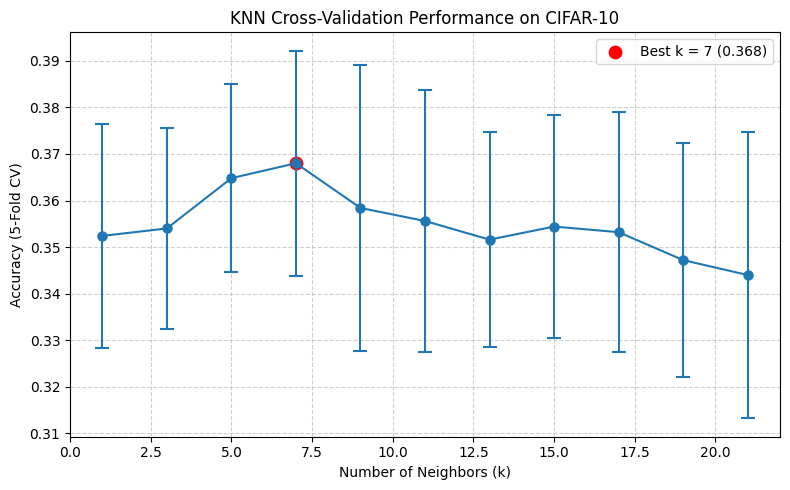

Best k (from CV): 7, mean accuracy = 0.3680


In [8]:
# Cell 8: Visualization of 5-Fold Cross Validation Results
# - Plot mean accuracy for each k with error bars
# - Display the best k value on the plot and in the console

plt.figure(figsize=(8, 5))
plt.errorbar(k_values, acc_means, yerr=acc_stds, fmt='-o', capsize=5, elinewidth=1.5, markeredgewidth=1.5)
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy (5-Fold CV)")
plt.title("KNN Cross-Validation Performance on CIFAR-10")
plt.grid(True, linestyle='--', alpha=0.6)

# Mark and annotate best k on the plot
plt.scatter(best_k, best_acc, color='red', s=80, label=f"Best k = {best_k} ({best_acc:.3f})")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Best k (from CV): {best_k}, mean accuracy = {best_acc:.4f}")
